In [146]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math as mt
import random as rand
from mpl_toolkits.mplot3d import axes3d
from statsmodels.nonparametric.smoothers_lowess import lowess as ls

from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

import seaborn as sns
sns.set()

ro.numpy2ri.activate()
pandas2ri.activate()

In [147]:
parser = lambda date: pd.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv("sorted.csv", parse_dates=[1], date_parser=parser, index_col=0)


In [148]:
def findDateIndex(date):
    # start date of first full day of observations in the data
    start_date = dt.date(2006, 12, 17)
    #how many days have passed between start date and input date
    days = (date - start_date).days

    # return the index: 60 obs/minute; 1440 obs/day
    # we return the csv row where our input date occurs
    return days*1440

In [149]:
def getRefWindow(num, wintype, date):
    idx = findDateIndex(date)

    #create empty data frames
    rf = pd.DataFrame([])
    tf = pd.DataFrame([])

    #now jump back (wintype = 7 for day_period, day, or week), and copy slices into our new DataFrame
    idx = idx - (num*1440*wintype)

    # add reference windows to dataframe
    for i in range(0,num):
      # I think the 1:2 is the global active power column
      rf = rf.append(data.iloc[idx+day_start:idx+day_end, 1:2])

      #output to csv for testing.
      temp = data.iloc[idx+day_start:idx+day_end, 1:2]
      temp.to_csv('ref' + str(i) + '.csv', header=False, index=False)

      # advance through the days and append
      idx = idx + (1440*wintype)

    # get test window
    tf = tf.append(data.iloc[idx+day_start:idx+day_end, 1:2])
    # output to csv
    tf.to_csv('testwin.csv', header=False, index=False)

    return rf.as_matrix(), tf

In [307]:
rstring="""
        function(){

            library("mhsmm")

            # grab the training window data
            data1 = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/ref0.csv",header=FALSE))
            data1 = as.numeric(data1)
            data1List = list(x=data1, N=length(data1))

            data2 = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/ref1.csv",header=FALSE))
            data2 = as.numeric(data2)
            data2List = list(x=data2, N=length(data2))

            data3 = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/ref2.csv",header=FALSE))
            data3 = as.numeric(data3)
            data3List = list(x=data3, N=length(data3))


            train = list(x=c(data1,data2,data3), N=c(length(data1),length(data2),length(data2)))
            class(train) <- "hsmm.data"

            # grab the testing window data
            
            dataT = as.matrix(read.csv("/Users/JRod/Desktop/Summer 2017/318D2/project/Otest1.7.csv",header=FALSE))
            dataT = as.numeric(dataT)
            test = list(x=dataT, N=length(dataT))
            class(test) <- "hsmm.data"


            # initialize values for learning the HSMM

            J <- 4
            M = 150

            d <- cbind(dunif(1:M,0,150),
                       dunif(1:M,0,150),
                       dunif(1:M,0,150),
                       dunif(1:M,0,150))

            start.np <- hsmmspec(init=rep(1/J,J),
                                 transition=matrix(c(.00,.5,.5,.5,
                                                     .5,.00,.5,.5,
                                                     .5,.50,.00,.50,
                                                     .5,.50,.50,.00),nrow=J),
                                 parms.emission=list(mu=c(0.5, 1.5, 2.5, 4),
                                                     sigma=c(0.75, 0.5, 0.5, 0.5)),
                                 sojourn=list(d=d,type='nonparametric'),
                                 dens.emission=dnorm.hsmm)

            #fit the model
            h.act <- hsmmfit(train,start.np,mstep=mstep.norm,M=M,graphical=FALSE)
            
            # predict on test window
            p_test <- predict(h.act,test)
            
            #predict each reference window
            p_ref0 <- predict(h.act,data1)
            p_ref1 <- predict(h.act,data2)
            p_ref2 <- predict(h.act,data3)

            # output for analysis
            
            em <- summary(h.act)
            
            output <- list(t1 = p_test$s, r0 = p_ref0$s, r1 = p_ref1$s, r2 = p_ref2$s, mu = em$mu, sigma = em$sigma) 
            
            output
           
        }
    """

In [308]:
###################
# Parameters
###################

test_date = dt.date(2007, 12, 21)

num_ref = 3
win_type = 7
day_start = 848
#1900
day_end = 848+1440

length = day_end - day_start

rw,tw = getRefWindow(num_ref, win_type, test_date)

In [309]:
tw.shape

(1440, 1)

In [310]:
rfunc=ro.r(rstring)
    # call the function in R and return the log likelyhood
predict=rfunc()

[1]
 4.684790e-20
 5.641896e-01


[1]
 6.423744e-60
 8.753861e-01


[1]
 7.037664e-79
 1.005520e+00


[1]
 1.637832e-99
 1.128787e+00


[1]
 1.095685e-110
  1.189714e+00


[1]
 1.538393e-116
  1.220456e+00


[1]
 1.201775e-121
  1.246625e+00


[1]
 2.184226e-124
  1.260291e+00


[1]
 1.910248e-126
  1.270430e+00


[1]
 6.155696e-128
  1.277699e+00


[1]
 7.804088e-129
  1.281972e+00


[1]
 1.602910e-129
  1.285202e+00


[1]
 3.139744e-130
  1.288598e+00


[1]
 7.101197e-131
  1.291691e+00


[1]
 2.124994e-131
  1.294194e+00


[1]
 8.760400e-132
  1.296027e+00


[1]
 4.530946e-132
  1.297385e+00


[1]
 2.705840e-132
  1.298441e+00


[1]
 1.735006e-132
  1.299349e+00


[1]
 1.127934e-132
  1.300224e+00


[1]
 7.217008e-133
  1.301131e+00


[1]
 4.443451e-133
  1.302112e+00


[1]
 2.569889e-133
  1.303220e+00


[1]
 1.41189e-133
  1.30443e+00


[1]
 7.793785e-134
  1.305627e+00


[1]
 4.476933e-134
  1.306739e+00


[1]
 2.685678e-134
  1.307761e+00


[1]
 1.685051e-134
  1.308692e+00


[1

In [311]:
# extract info from R ouput

seq0 = np.asarray(predict[0])
seq1 = np.asarray(predict[1])
seq2 = np.asarray(predict[2])
seq3 = np.asarray(predict[3])

obs_mu = np.asarray(predict[4])
obs_sigma = np.asarray(predict[5])

#to plot mu for the each state
seq_int = np.array(seq0, dtype=int)

print(obs_sigma)
print(obs_mu)

[ 0.0890941   0.13946212  0.21799205  1.00076198]
[ 0.55276839  1.42217045  2.13300737  3.26653316]


In [312]:
def checkPoint(testw, ts, i, threshold):
    
    dist = abs(testw[i] - obs_mu[int(ts[i])-1])
    
    if ( dist > obs_sigma[int(ts[i])-1]*threshold):
          return dist, testw[i]
    else:
          return 0, None
    

In [313]:
# determine mean and sigma
# observations, mu and sigma, state sequence

def getPASD(testw, ts, threshold1, threshold2, threshold3, threshold4):
    
    
    
    
    point_anom = np.zeros(ts.shape[0])
    new_plot = np.zeros(ts.shape[0])
    
    for i in range(ts.shape[0]):
        
        if (int(ts[i]) == 1):
           dist, newp = checkPoint(testw, ts, i, threshold1)
        
        elif (int(ts[i]) == 2):
           dist, newp = checkPoint(testw, ts, i, threshold2)
        
        elif (int(ts[i]) == 3):
           dist, newp = checkPoint(testw, ts, i, threshold3)
        
        elif (int(ts[i]) == 4):
           dist, newp = checkPoint(testw, ts, i, threshold4)
           
             
        point_anom[i] = dist
        new_plot[i] = newp 
    
    
    return point_anom, new_plot
    

In [314]:
def getPAKNN(testw, ts, K, threshold):
    
    # magnitude of PA's
    point_anom = np.zeros(testw.shape[0])
    # a new plot containing PAs, and nothing otherwise, so we can superimpose over the original plot
    new_plot = np.zeros(ref0.shape[0])
    
    
    w = int(mt.floor(K / 2))
    new_plot[0:w] = None
    
    
    for i in range(w, testw.shape[0]):
        
        dist = np.mean(abs(ts[i] - np.concatenate((ts[i-w:i], ts[i+1:i+w+1]))))
        
        if (dist >= threshold ):
            point_anom[i] = dist
            new_plot[i] = testw[i]
        else:
            point_anom[i] = 0
            new_plot[i] = None
            
    return point_anom, new_plot
        

In [315]:
# tw = observation array, ts = sequence array
def cleanSeq(testw, ts, K, tstate, tobs):
    
    new_ts = np.copy(ts)
    #new_ts = np.zeros(ts.shape[0])
    state_changes = np.zeros(ts.shape[0])
    
    w = int(mt.floor(K / 2))
    
    for i in range(w, ts.shape[0]):
        
        # is it anomalous?
        state_dist = np.mean(abs(ts[i] - np.concatenate((ts[i-w:i], ts[i+1:i+w+1]))))
    
        
        if (state_dist > tstate):
            # if it is, is it a false positive?
            obs_dist = abs(np.mean(float(testw[i]) - np.concatenate((testw[i-w:i], testw[i+1:i+w+1]))))
        
            if (obs_dist <= tobs):
                #get new state
                
                new_state = int( (np.sum(ts[i-w:i]) + np.sum(ts[i+1:i+1+w])) / (w*2))
                new_ts[i] = new_state
                state_changes[i] = new_state  
        
            
    return state_changes, new_ts

In [316]:
tw = pd.read_csv("Otest1.7.csv", header=None)
ref0 = pd.read_csv("ref0.csv", header=None)
ref1 = pd.read_csv("ref1.csv", header=None)
ref2 = pd.read_csv("ref2.csv", header=None)

tw = tw.as_matrix().reshape((tw.shape[0],))
ref0 = ref0.as_matrix().reshape((ref0.shape[0],))
ref1 = ref1.as_matrix().reshape((ref1.shape[0],))
ref2 = ref2.as_matrix().reshape((ref2.shape[0],))


In [317]:

t = np.array(seq0, dtype=int)


In [318]:
s = obs_mu[t-1]


In [319]:
seq0[149]

4.0

In [320]:
# run a Lowess filter to remove state fluctuations

new_tsx = np.array(range(seq0.shape[0]))
new_ts = ls(seq0, new_tsx, frac=0.06)
new_ts = np.array(np.round(new_ts[0:,1]), dtype=int)
new_ts[new_ts>4] = 4
mu_plot2 = obs_mu[new_ts-1]



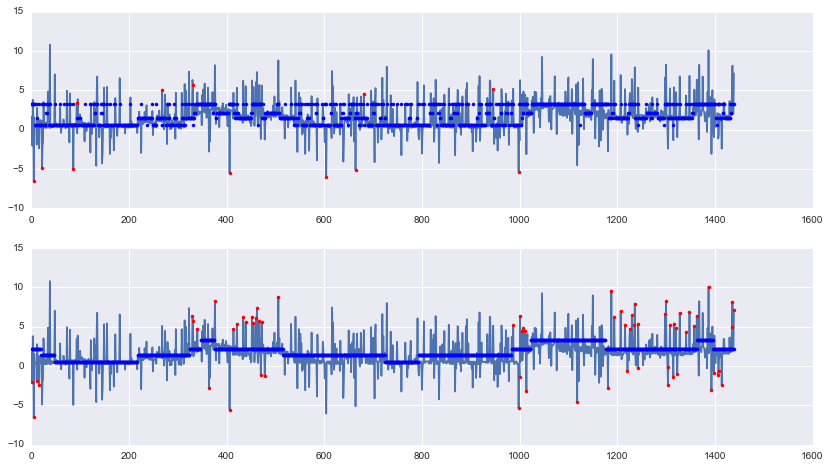

In [321]:
mu_plot = obs_mu[np.array(seq0-1, dtype=int)]
point_anom2, new_tw1 = getPASD(tw, seq0, 30,60,10,8)

point_anom1, new_tw2 = getPASD(tw, new_ts, 120,80,10,6)

plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(mu_plot, 'b.')
plt.plot(new_tw1, 'r.')
plt.subplot(312)


plt.plot(tw)
plt.plot(mu_plot2, 'b.')
plt.plot(new_tw2, 'r.')
plt.show()

In [322]:
new_tw2[np.isnan(new_tw2) == False] = 1
new_tw2[np.isnan(new_tw2) == True] = 0

np.savetxt('anom7.csv', new_tw2)


In [86]:
#K = 4 max dist is 2.39ish

#
# test PA detection filters
#

point_anom1, new_tw1 = getPAKNN(tw, seq0, 4, .7)
state_changes, new_ts = cleanSeq(tw, seq0, 4, .7, 2)
point_anom2, new_tw2 = getPAKNN(tw, new_ts, 4, .7)
new_ts = np.array(new_ts, dtype=int)

In [87]:
i=158
w = 2
#test = np.mean(abs(float(seq0[i]) - seq0[i-w:i+w+1]))
test = np.mean(abs(seq0[i] - seq0[i-w:i+w+1]))
obs_dist = abs(np.mean(float(tw[i]) - tw[i-w:i+w+1]))
state_dist = np.mean(abs(seq0[i] - np.concatenate((seq0[i-w:i], seq0[i+1:i+w+1]))))


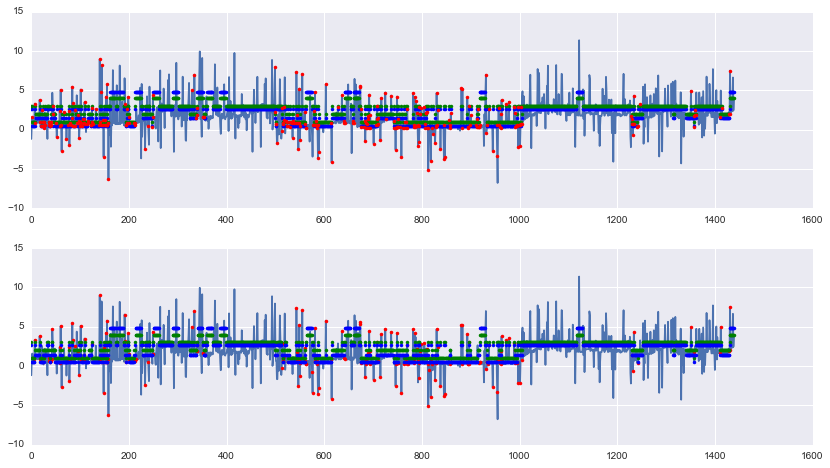

In [88]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(mu_plot, 'b.')
plt.plot(seq0, 'g.')
plt.plot(new_tw1, 'r.')
plt.subplot(312)
#plt.plot(tw)
plt.plot(tw)
plt.plot(new_tw2, 'r.')
plt.plot(new_ts, 'g.')
plt.plot(obs_mu[new_ts-1], 'b.')
plt.show()

In [89]:
#
# Test collective anomaly detection filters
#


In [90]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(seq0, 'go')
plt.subplot(312)
plt.plot(ref0)
plt.plot(seq1, 'go')
plt.subplot(313)
plt.plot(test1, 'ro')
plt.show()

NameError: name 'test1' is not defined

In [91]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(seq0, 'go')
plt.subplot(312)
plt.plot(ref1)
plt.plot(seq2, 'go')
plt.subplot(313)
plt.plot(test2, 'ro')
plt.show()

NameError: name 'test2' is not defined

In [93]:
# sum of the sequence arrays

new_tsx = np.array(range(seq0.shape[0]))

new_seq0 = ls(seq0, new_tsx, frac=0.06)
new_seq1 = ls(seq1, new_tsx, frac=0.06)
new_seq2 = ls(seq2, new_tsx, frac=0.06)
new_seq3 = ls(seq3, new_tsx, frac=0.06)

new_seq0 = np.array(np.round(new_seq0[0:,1]), dtype=int)
new_seq1 = np.array(np.round(new_seq1[0:,1]), dtype=int)
new_seq2 = np.array(np.round(new_seq2[0:,1]), dtype=int)
new_seq3 = np.array(np.round(new_seq3[0:,1]), dtype=int)

new_seq0[new_seq0>4] = 4
new_seq1[new_seq1>4] = 4
new_seq2[new_seq2>4] = 4
new_seq3[new_seq3>4] = 4

test1 = abs(new_seq0 - new_seq1) # test vs ref0
test2 = abs(new_seq0 - new_seq2) # test vs ref1
test3 = abs(new_seq0 - new_seq3) # test vs ref2

seqsum = test1 + test2 + test3

col_mu_plot = obs_mu[new_seq0-1]

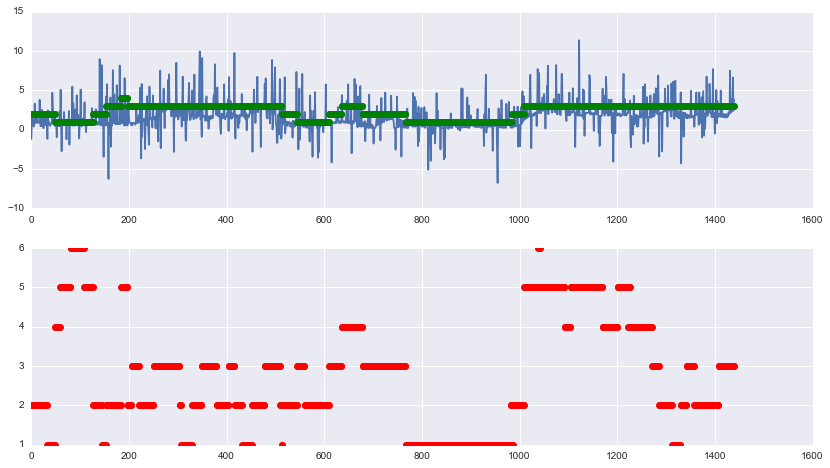

In [95]:
plt.figure(figsize=(14, 12))
plt.subplot(311)
plt.plot(tw)
plt.plot(new_seq0, 'go')
plt.subplot(312)
plt.plot(seqsum, 'ro')
plt.show()

In [96]:
#
# Maximum avg subarray parameters
#


#max/min length -- these need to have (max-min) >= 2 for a single window
max_length = 100
min_length = 10

# density threshold
dt = 4.5
# initial window size
k = max_length
#max number of scores
score_max = 5
#number of window sizes
w = int(mt.floor(mt.log((max_length-min_length), 2)))

In [97]:
int(mt.floor(mt.log((max_length-min_length), 2)))

6

In [98]:
X = np.zeros(w*length)
Y = np.zeros(w*length)
Z = np.zeros(w*length)

for i in range(w):
  X[i*length:i*length+length] = i+1
  Y[i*length:i*length+length] = np.arange(length)

dx = np.ones(w*length)
dy = np.ones(w*length)
dz = np.zeros(w*length)

#heatmap
CA = np.zeros((w,tw.shape[0]))
y_label = np.zeros(w)


In [99]:
#
# max avg subarray algorithm
#


for i in range(0,w):

    # reset number of scores for this window size
    score_count = 0
    #slide the window over everything, take scores over the threshold
    for j in range(0,tw.shape[0] - (k-1)):

      s = float(np.sum(seqsum[j:j+k]))

      d = float(s / k)
        
      #print(arr[j:j+k], " ", d, d>dt, " ", ((j+k+j)/2))
      if ((d > dt)):
          
          CA[i,j] += d
          #Z[i*length+int((j+k+j)/2)] += d
          #print(Z[int((j+k+j)/2),i], " ", d, " ", j, " ", j+k, " ", int((j+k+j)/2))
          score_count += 1

    # add label to graph, cut the window size in half
    y_label[i] = int(k)
    k = int(mt.floor(k / 2))
    



In [464]:
CA[CA<5.5] = 0


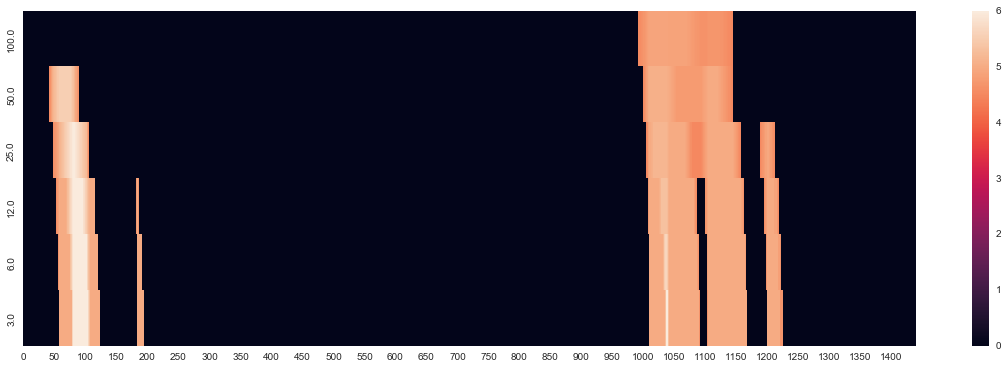

In [100]:
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(CA, xticklabels=50, yticklabels=y_label )
plt.show()
